# MY NLP MODELING EXERCISES

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re
import env
import acquire
import prepare
from wordcloud import WordCloud
import nltk.sentiment
pd.set_option('display.max_colwidth', None)
from time import strftime
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#acquire data from spam_db

from env import user, password, host
raw = pd.read_csv("spam_clean - spam_clean.csv")

raw.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [3]:
raw['cleaned']=raw.text.apply(prepare.basic_clean).apply(prepare.tokenize)\
.apply(prepare.remove_stopwords, extra_words=[], 
                                   exclude_words=[])
raw['stemmed'] = raw.cleaned.apply(prepare.stem)
raw['lemmatized']= raw.cleaned.apply(prepare.lemmatize)
raw = raw.drop(columns=['text','cleaned','stemmed'])
raw.head()

,label,lemmatized
0,ham,go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s
3,ham,u dun say early hor u c already say
4,ham,nah dont think go usf life around though


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       5572 non-null   object
 1   lemmatized  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
raw.shape

(5572, 2)

<AxesSubplot:xlabel='label', ylabel='count'>

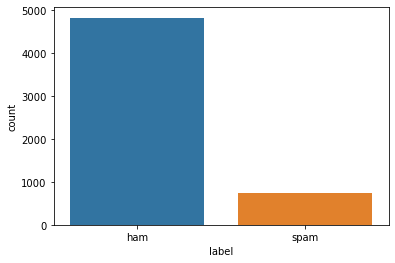

In [6]:
sns.countplot(data=raw,x='label')

# I'm really interested in applying SMOTE to the spam data to equal out the number of observations for either category

In [7]:
raw.label.mode()

0    ham
dtype: object

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


df = raw
df.head()

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [9]:
train

,actual,predicted
1584,ham,ham
161,ham,ham
3906,ham,ham
1568,ham,ham
1640,ham,ham
...,...,...
3942,ham,ham
5524,spam,spam
3742,ham,ham
4987,ham,ham


In [10]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 96.59%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3854   147
spam          5   451
---
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      3859
        spam       0.99      0.75      0.86       598

    accuracy                           0.97      4457
   macro avg       0.98      0.88      0.92      4457
weighted avg       0.97      0.97      0.96      4457



In [11]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))


Accuracy: 94.98%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        962    52
spam         4    97
---
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       966
        spam       0.96      0.65      0.78       149

    accuracy                           0.95      1115
   macro avg       0.95      0.82      0.87      1115
weighted avg       0.95      0.95      0.95      1115



# Up to here, this notebook follows the lesson

# From here, attempting to apply a Random Forest model

In [13]:
# This will be our baseline value for our Random Forest model

y_train.mode()

0    ham
dtype: object

In [14]:
# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 'ham'

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.87


In [15]:
# Make the model
forest1 = RandomForestClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
forest1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True,zero_division=0)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,ham,spam,accuracy,macro avg,weighted avg
precision,0.865829,0.0,0.865829,0.432915,0.749660
recall,1.000000,0.0,0.865829,0.500000,0.865829
f1-score,0.928090,0.0,0.865829,0.464045,0.803568
support,3859.000000,598.0,0.865829,4457.000000,4457.000000


In [16]:
train_rf = pd.DataFrame(dict(actual=y_train))
test_rf = pd.DataFrame(dict(actual=y_test))

train_rf['predicted_rf'] = forest1.predict(X_train)
test_rf['predicted_rf'] = forest1.predict(X_test)

In [17]:
print('Accuracy: {:.2%}'.format(accuracy_score(train_rf.actual, train_rf.predicted_rf)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_rf.predicted_rf, train_rf.actual))
print('---')
print(classification_report(train_rf.actual, train_rf.predicted_rf, zero_division=0))

Accuracy: 86.58%
---
Confusion Matrix
actual         ham  spam
predicted_rf            
ham           3859   598
---
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93      3859
        spam       0.00      0.00      0.00       598

    accuracy                           0.87      4457
   macro avg       0.43      0.50      0.46      4457
weighted avg       0.75      0.87      0.80      4457



In [18]:
# sklearn confusion matrix
pd.DataFrame(confusion_matrix(y_predictions, y_train))

,0,1
0,3859,598
1,0,0


In [19]:
# I'm building models on multiple max depths here:
for i in range(2, 11):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True,zero_division=0)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                   ham   spam  accuracy    macro avg  weighted avg
precision     0.865829    0.0  0.865829     0.432915      0.749660
recall        1.000000    0.0  0.865829     0.500000      0.865829
f1-score      0.928090    0.0  0.865829     0.464045      0.803568
support    3859.000000  598.0  0.865829  4457.000000   4457.000000

Tree with max depth of 3
                   ham   spam  accuracy    macro avg  weighted avg
precision     0.865829    0.0  0.865829     0.432915      0.749660
recall        1.000000    0.0  0.865829     0.500000      0.865829
f1-score      0.928090    0.0  0.865829     0.464045      0.803568
support    3859.000000  598.0  0.865829  4457.000000   4457.000000

Tree with max depth of 4
                   ham   spam  accuracy    macro avg  weighted avg
precision     0.865829    0.0  0.865829     0.432915      0.749660
recall        1.000000    0.0  0.865829     0.500000      0.865829
f1-score      0.928090    0.0  0.865829     0.464045

# Linear Regression is beating the Random Forest for accuracy on every max depth

# How do the models compare when trained on term frequency data alone (instead of TF-IDF values)?

In [20]:
raw.head()

,label,lemmatized
0,ham,go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s
3,ham,u dun say early hor u c already say
4,ham,nah dont think go usf life around though


In [30]:
documents = raw.lemmatized.head()
documents.head()

0                                                         go jurong point crazy available bugis n great world la e buffet cine got amore wat
1                                                                                                                    ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s
3                                                                                                        u dun say early hor u c already say
4                                                                                                   nah dont think go usf life around though
Name: lemmatized, dtype: object

In [26]:
# We will create an empty list to store values for us as we iterate through our data
tfs = []

In [34]:
# Start by iterating over all the documents. We can use .items() to speed up our loop:
documents.items()

In [35]:
# Create a for loop
for text in documents.items():
    # We will make a dataframe that contains the term frequency for every word
    df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(df)

AttributeError: 'tuple' object has no attribute 'split'

# What adam did:

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X_bag_of_wrds= cv.fit_transform(df.lemmatized)
y = df.label

In [40]:
cv.get_feature_names()

['008704050406',
 '0089my',
 '0121',
 '01223585236',
 '01223585334',
 '0125698789',
 '02',
 '020603',
 '0207',
 '02070836089',
 '02072069400',
 '02073162414',
 '02085076972',
 '020903',
 '021',
 '050703',
 '0578',
 '06',
 '060505',
 '061104',
 '07008009200',
 '07046744435',
 '07090201529',
 '07090298926',
 '07099833605',
 '071104',
 '07123456789',
 '0721072',
 '07732584351',
 '07734396839',
 '07742676969',
 '07753741225',
 '0776xxxxxxx',
 '07786200117',
 '077xxx',
 '078',
 '07801543489',
 '07808',
 '07808247860',
 '07808726822',
 '07815296484',
 '07821230901',
 '0784987',
 '0789xxxxxxx',
 '0794674629107880867867',
 '0796xxxxxx',
 '07973788240',
 '07xxxxxxxxx',
 '0800',
 '08000407165',
 '08000776320',
 '08000839402',
 '08000930705',
 '08000938767',
 '08001950382',
 '08002888812',
 '08002986030',
 '08002986906',
 '08002988890',
 '08006344447',
 '0808',
 '08081263000',
 '08081560665',
 '0825',
 '0844',
 '08448350055',
 '08448714184',
 '0845',
 '08450542832',
 '08452810071',
 '08452810073'

In [41]:
cv.vocabulary_

{'go': 3617,
 'jurong': 4472,
 'point': 6078,
 'crazy': 2416,
 'available': 1401,
 'bugis': 1838,
 'great': 3708,
 'world': 8623,
 'la': 4621,
 'buffet': 1836,
 'cine': 2151,
 'got': 3670,
 'amore': 1173,
 'wat': 8403,
 'ok': 5673,
 'lar': 4657,
 'joking': 4442,
 'wif': 8528,
 'oni': 5704,
 'free': 3423,
 'entry': 3036,
 'wkly': 8579,
 'comp': 2259,
 'win': 8541,
 'fa': 3166,
 'cup': 2468,
 'final': 3277,
 'tkts': 7867,
 '21st': 429,
 'may': 5064,
 '2005': 416,
 'text': 7717,
 '87121': 823,
 'receive': 6448,
 'questionstd': 6344,
 'txt': 8063,
 'ratetcs': 6395,
 'apply': 1261,
 '08452810075over18s': 71,
 'dun': 2894,
 'say': 6776,
 'early': 2915,
 'hor': 4022,
 'already': 1146,
 'nah': 5373,
 'dont': 2811,
 'think': 7789,
 'usf': 8208,
 'life': 4741,
 'around': 1309,
 'though': 7807,
 'freemsg': 3431,
 'hey': 3923,
 'darling': 2530,
 'week': 8448,
 'word': 8611,
 'back': 1448,
 'id': 4138,
 'like': 4756,
 'fun': 3490,
 'still': 7393,
 'tb': 7654,
 'xxx': 8745,
 'std': 7369,
 'chgs': 20

In [42]:
bow = pd.DataFrame(X_bag_of_wrds.todense(), columns=cv.get_feature_names())
bow

,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,0207,02070836089,...,zebra,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
bow['win']

0       0
1       0
2       1
3       0
4       0
       ..
5567    0
5568    0
5569    0
5570    0
5571    0
Name: win, Length: 5572, dtype: int64

In [44]:
bow['win'].sum()

76

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
train = pd.DataFrame(dict(actual=y_train))
test= pd.DataFrame(dict(actual=y_test))

# continue copying adam's code in here

## Bonus: Can we use n-grams as a feature engineering method?

In [48]:
from pprint import pprint
cv = CountVectorizer(ngram_range=(2, 2))
bigrams = cv.fit_transform(df.lemmatized)

pprint(df.lemmatized)
pd.DataFrame(bigrams.todense(), columns=cv.get_feature_names())

0                                                            go jurong point crazy available bugis n great world la e buffet cine got amore wat
1                                                                                                                       ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s
3                                                                                                           u dun say early hor u c already say
4                                                                                                      nah dont think go usf life around though
                                                                         ...                                                                   
5567                            2nd time tried 2 contact u u a750 pound prize 2 claim easy call 087187272008 now1 10p per minute btnatio

,008704050406 sp,0089my last,0121 2025050,01223585236 xx,01223585334 cum,0125698789 ring,02 user,020603 2nd,0207 153,02072069400 bx,...,zed pobox,zero saving,zhong se,zindgi wo,zoe 18,zoe hit,zogtorius iaove,zoom cine,zouk nichols,zyada kisi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
pd.DataFrame(bigrams.todense(), columns=cv.get_feature_names())['go jurong']

0       1
1       0
2       0
3       0
4       0
       ..
5567    0
5568    0
5569    0
5570    0
5571    0
Name: go jurong, Length: 5572, dtype: int64

In [54]:
pd.DataFrame(bigrams.todense(), columns=cv.get_feature_names())['go jurong'].sum()

1